In [1]:
import numpy as np
import matplotlib.pyplot as plt
from time import time

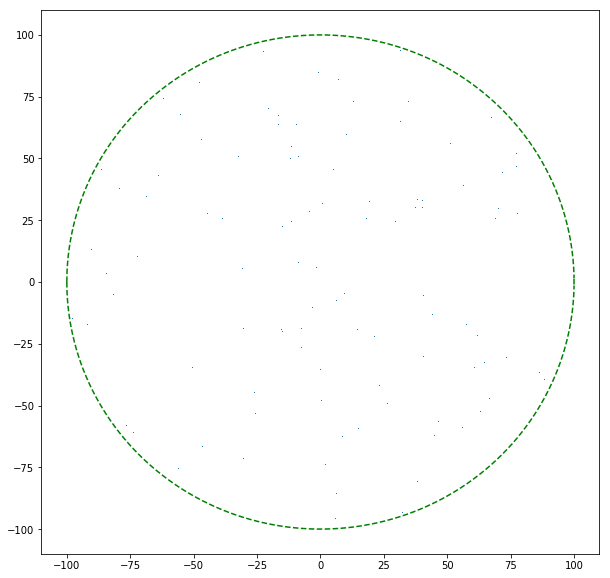

In [2]:
# A = 5 
# B = 9
N = 100
radius = 100
h = 0.0001 #step
delta = 0.1
# alpha=2
# epsilon=0.01

old_coords=coordinates_of_all_points = np.random.normal(loc = (0, 0),size =(N, 2))*radius
old_veloc =velocities_of_all_points = np.random.rand(N, 2)

while (np.sum(np.linalg.norm(coordinates_of_all_points, axis = 1)>radius)>0):
    length = np.sum(np.linalg.norm(coordinates_of_all_points, axis = 1)>radius)
    substitution_matrix = np.random.normal(loc = (0, 0),size =(length, 2))* radius
    coordinates_of_all_points[np.linalg.norm(coordinates_of_all_points, axis = 1)>radius] = substitution_matrix

# print("Coordinates of all points:\n", coordinates_of_all_points, \
#       "\n\nVelocities of all points:\n", velocities_of_all_points)
x_boundary = np.arange(-radius, radius, 0.01)
y_boundary = np.sqrt(radius**2 - x_boundary**2)
plt.figure(figsize=(10,10))
plt.plot(coordinates_of_all_points[:,0], coordinates_of_all_points[:,1], ",")
plt.plot(x_boundary, y_boundary, "g--")
plt.plot([radius, radius], [y_boundary[-1], -y_boundary[-1]], "g--")
plt.plot(x_boundary, -y_boundary, "g--")
plt.show()

In [3]:
# def new_coordinates()

## FMM function: 

In [4]:
def acceleration(eta, epsilon, alpha):
    return (eta / ((np.linalg.norm(eta) + epsilon)**alpha))

In [5]:
eta = np.ones(2)

    
def find_FMM_acceleration(A, B, point_ID, delta_velocity, delta_time, middle=[0, 0]):
    velocity = velocities_of_all_points[point_ID] + delta_velocity
    FMM_accel = (   A-B*np.power(np.linalg.norm(velocity), 2)   )*velocity
    
    x_i = velocity * delta_time + coordinates_of_all_points[point_ID] #Runge-Kutta
    x_i = x_i - middle
    term_1 = acceleration(x_i - middle, epsilon, alpha)    
    
    
    source_IDs = np.arange(N)
    source_IDs = source_IDs[source_IDs != point_ID]
    for body_ID in source_IDs:
        x_j = velocities_of_all_points[body_ID] * delta_time + coordinates_of_all_points[body_ID] #Runge-Kutta
        term_3 = (x_j - middle)/x_i
        FMM_accel += term_1 * (term_initial + term_coefficient @term_3)
    return FMM_accel

In [6]:
def force_of_interaction(velocity1, point_ID1, point_ID2, delta_time):
    old_coord_diff = coordinates_of_all_points[point_ID2]- coordinates_of_all_points[point_ID1]
    old_velocity_diff = velocities_of_all_points[point_ID2]- velocity1
    new_coord_diff = old_velocity_diff * delta_time + old_coord_diff
    return new_coord_diff/np.power(np.linalg.norm(new_coord_diff), alpha)

In [7]:
def find_acceleration(point_ID, delta_velocity, delta_time):
    velocity = velocities_of_all_points[point_ID] + delta_velocity
    return (   A-B*np.power(np.linalg.norm(velocity), 2)   )*velocity+\
            np.sum([force_of_interaction(velocity, point_ID, body_ID, delta_time) if body_ID != point_ID else [0, 0] for body_ID in np.arange(N)], axis = 0)

In [8]:
def k_1_computation(A, B, point_ID):
    return h*find_FMM_acceleration(A, B, point_ID, 0, 0)

In [9]:
def k_2_computation(A, B, point_ID):
    return h*find_FMM_acceleration(A, B, point_ID, k_1_computation(A, B, point_ID), h)

In [10]:
def update_velocity(A, B, point_ID):
    return velocities_of_all_points[point_ID] + (k_1_computation(A, B, point_ID) + k_2_computation(A, B, point_ID))/2

In [11]:
def reflection(point_ID):
    p = coordinates_of_all_points[point_ID]
    v = velocities_of_all_points[point_ID]
    HH = v
    if np.dot(v, p) > 0:
        normal_vec = p / np.linalg.norm(p)
        normal_vec = normal_vec.reshape(-1, 1)
        Householder_matrix = np.identity(2) - 2 * normal_vec @ normal_vec.T
        HH = Householder_matrix @ v
    return HH

In [ ]:
# velocities_of_all_points = np.asarray([update_velocity(point_ID) for point_ID in np.arange(N)])
# coordinates_of_all_points -= velocities_of_all_points * h

In [ ]:
# print("Coordinates of all points:\n", coordinates_of_all_points, \
#       "\n\nVelocities of all points:\n", velocities_of_all_points)


In [ ]:
plt.close('all')
arrow_scale = 3

alpha_array = [1, 2, 3, 4]
epsilon_array = [1e-4, 1e-3, 1e-2, 1e-1]

AB_array = np.arange(0, 10, 1)
diff_time = []
for alpha in alpha_array:
    for epsilon in epsilon_array:
        term_initial = acceleration(np.ones(2), epsilon, alpha)
        term_coefficient = np.identity(2) / ((np.linalg.norm(eta) + epsilon)**alpha)
        term_coefficient = term_coefficient @ (    np.identity(2) -\
                                               alpha * eta * ((eta.T @ eta)/((np.linalg.norm(eta) + epsilon)))   )

        for A in AB_array:
            for B in AB_array:
                coordinates_of_all_points = old_coords
                velocities_of_all_points = old_veloc
                time_start = time()
                for j in range(100):
                    plt.close('all')
                    velocities_of_all_points = np.asarray([update_velocity(A, B, point_ID) for point_ID in np.arange(N)])

                    plt.figure(figsize=(10,10))
                    plt.plot(coordinates_of_all_points[:,0], coordinates_of_all_points[:,1], ",")
                    for i in range(N):
                        plt.arrow(coordinates_of_all_points[i,0], coordinates_of_all_points[i,1], velocities_of_all_points[i,0] * arrow_scale, velocities_of_all_points[i,1] * arrow_scale, shape='full', lw=0.5, length_includes_head=True, head_width=1)

                    coordinates_of_all_points += velocities_of_all_points * h

                    indices = coordinates_of_all_points[:,0]**2 + coordinates_of_all_points[:,1]**2 > (radius*(1- delta))**2 

                    point_ID = 0
                    for ind in indices:
                        if ind == True:
                #             plt.plot(x_boundary, y_boundary, "g--")
                #             plt.plot([radius, radius], [y_boundary[-1], -y_boundary[-1]], "g--")
                #             plt.plot(x_boundary, -y_boundary, "g--")
                #             plt.title("Frame #%i. Reflection of %i" % (j, point_ID))
                #             plt.savefig(('images/%i.%i.png'% (j, point_ID)))
                #             plt.show()
                            velocities_of_all_points[point_ID]= reflection(point_ID)            
                #             plt.figure(figsize=(10,10))
                #             plt.plot(coordinates_of_all_points[:,0], coordinates_of_all_points[:,1], ",")
                #             for i in range(N):
                #                 plt.arrow(coordinates_of_all_points[i,0], coordinates_of_all_points[i,1], velocities_of_all_points[i,0] * arrow_scale, velocities_of_all_points[i,1] * arrow_scale, shape='full', lw=0.5, length_includes_head=True, head_width=1)
                        point_ID += 1

                    plt.plot(x_boundary, y_boundary, "g--")
                    plt.plot([radius, radius], [y_boundary[-1], -y_boundary[-1]], "g--")
                    plt.plot(x_boundary, -y_boundary, "g--")
                    plt.title("Frame #%i" % j)
                    plt.savefig(('images3/A=%0.1f B=%0.1f eps=%0.4f alp=%0.1f Frame=%i.png'% (A, B, epsilon, alpha, j) ))
                #     plt.show()

                time_end = time()
                diff_time.append(time_end - time_start)
                print((time_end - time_start))

        
np.savetxt("TIME_A_B_epsilon_alpha.txt", diff_time)
        
        


38.072826862335205
37.809317111968994
37.71779489517212
36.975528955459595
36.745139360427856
38.37153673171997
62.62151789665222
60.07229018211365
45.55297899246216
45.66063904762268
64.58787775039673
72.04911780357361
62.02820158004761
65.861319065094
72.13852000236511
64.15758347511292
67.77154278755188
63.570215702056885
68.16605877876282
60.87163996696472
69.02286672592163
70.59383726119995
75.7737603187561
151.13975310325623
69.7528805732727
72.76950764656067
77.35752129554749
78.29301834106445
82.69464421272278
188.1182644367218
80.14479398727417
81.00727200508118
84.50153541564941
83.77432513237
78.37734270095825
74.92549109458923
303.887327671051
82.10116147994995
122.81018686294556
103.64489960670471
102.73708820343018
